<a href="https://colab.research.google.com/github/Ollldman/ml_dl_experiments/blob/main/ml_dl_experiments/dl/dl_modules/second_theme_PyTorch/4.MLP_for_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

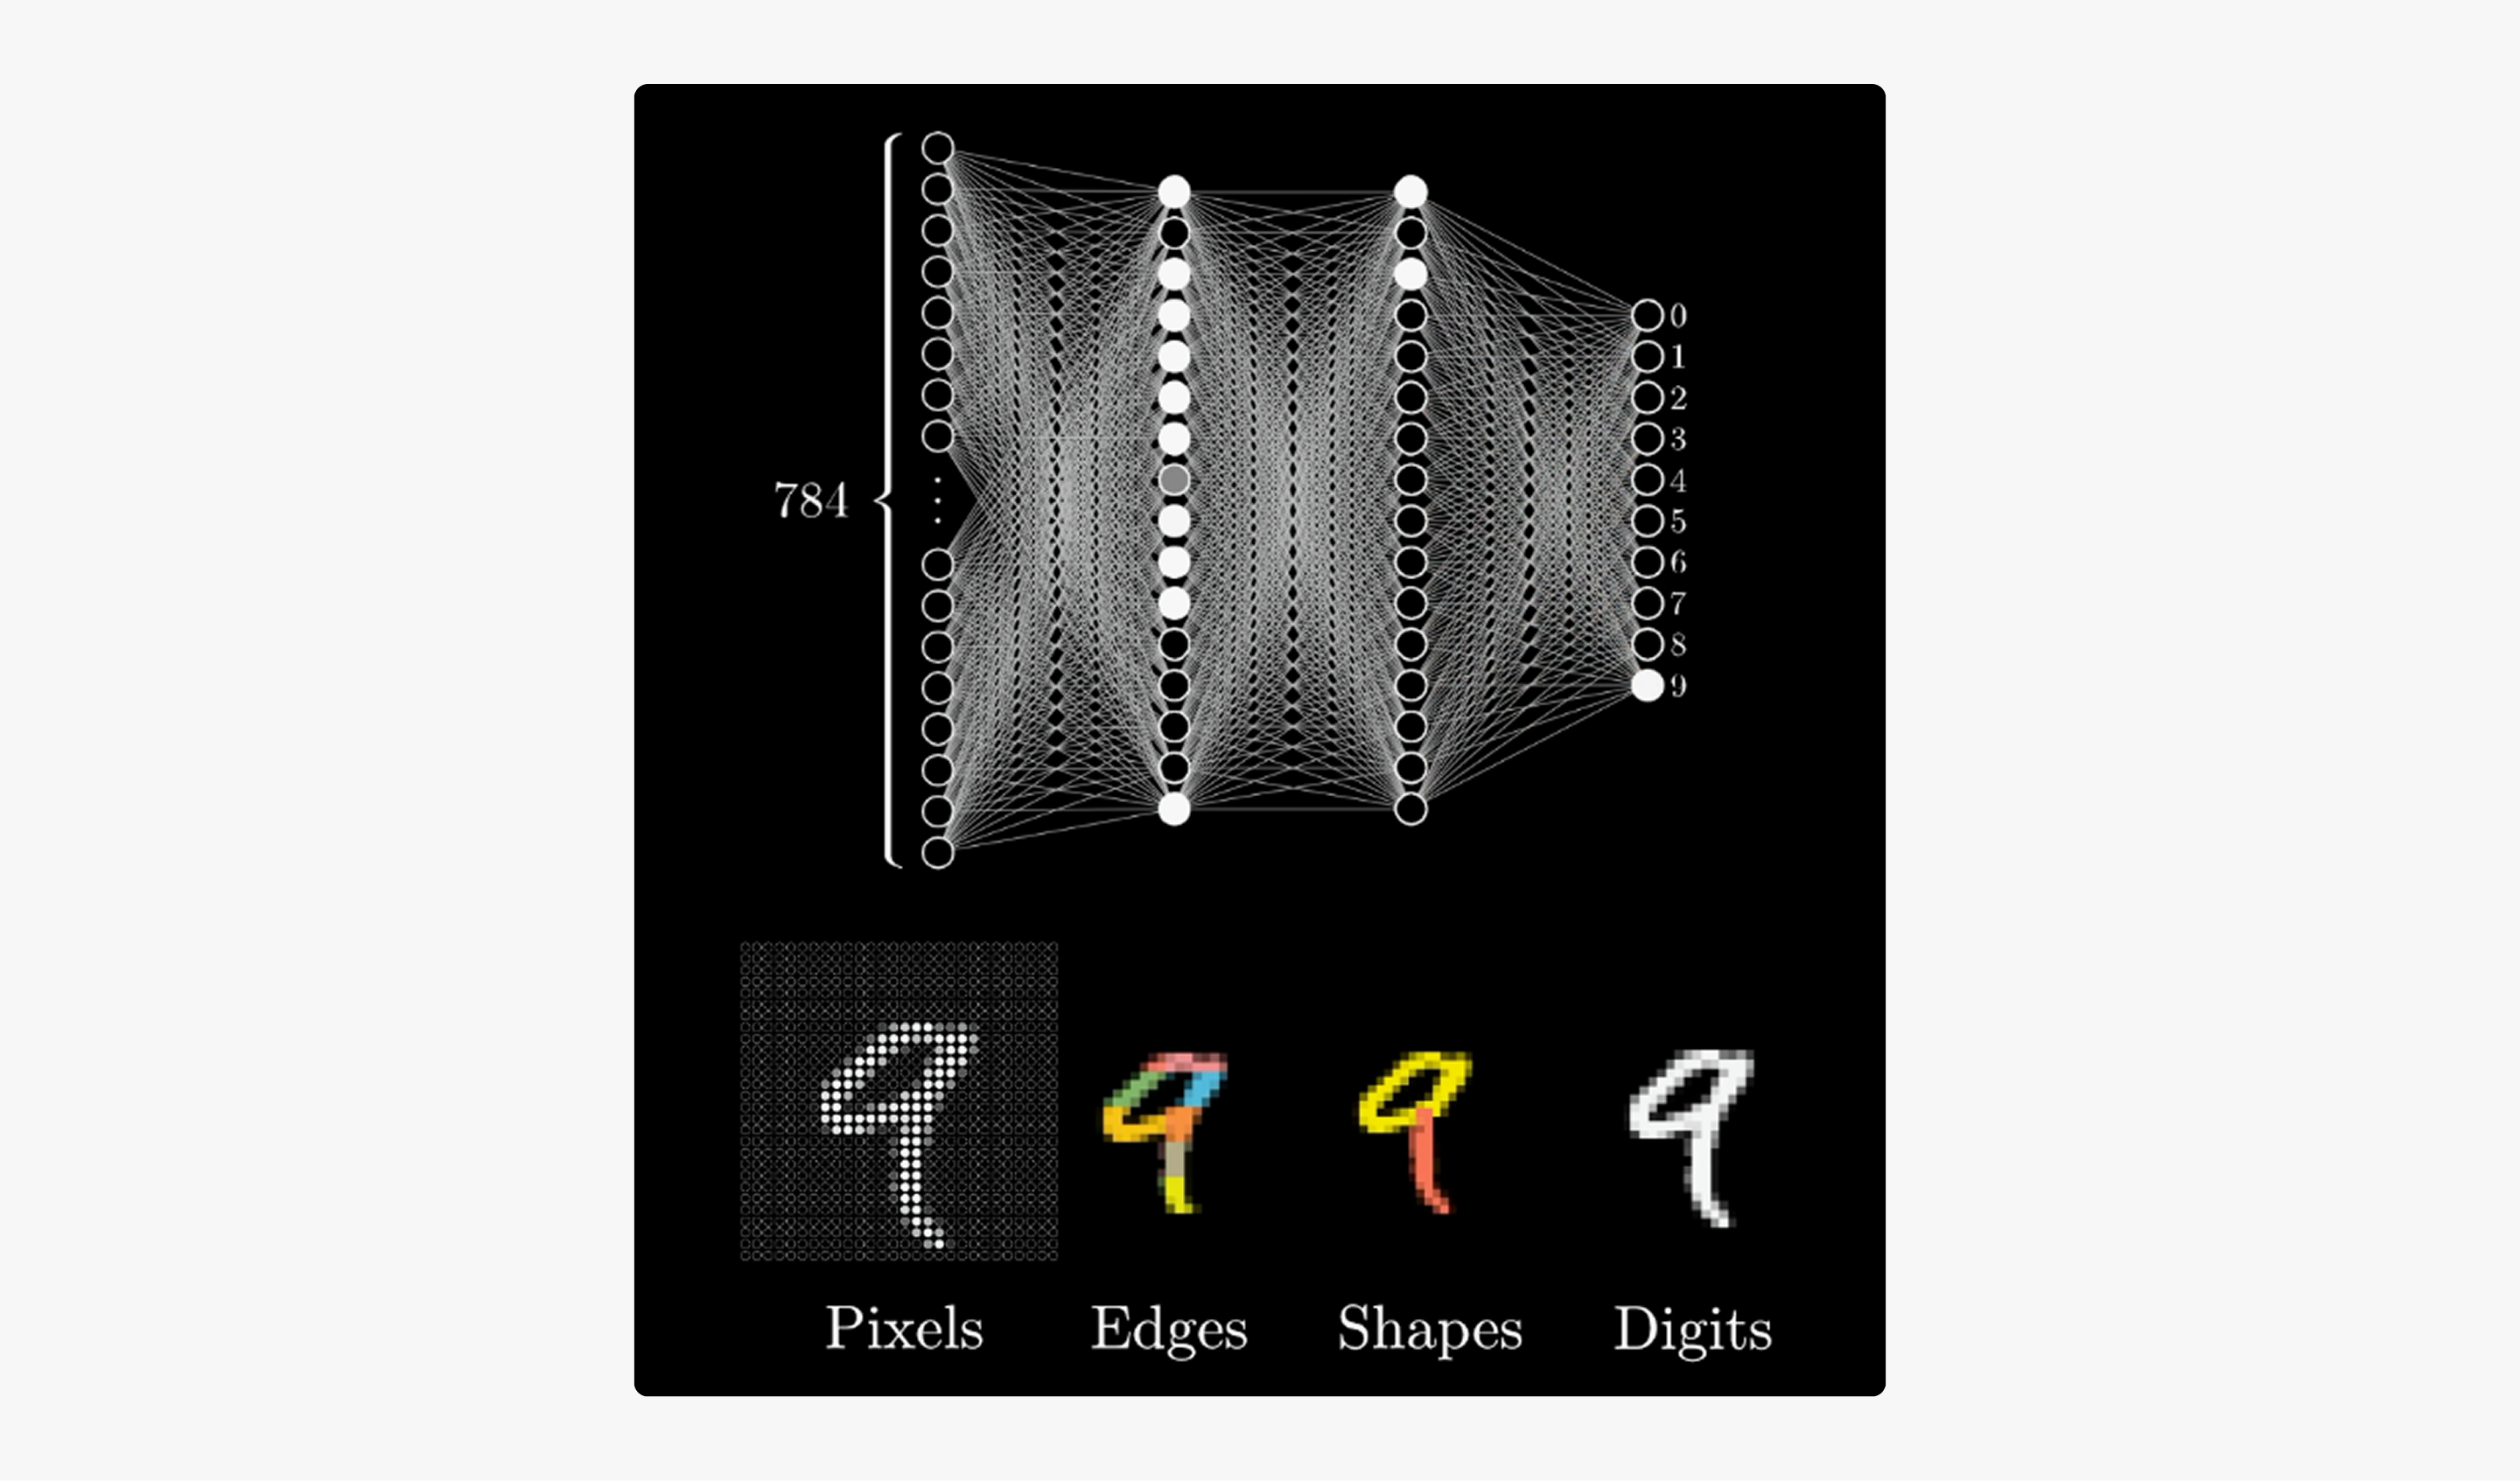

In [ ]:
from IPython.display import Image
from ml_dl_experiments.settings import settings
Image(filename=settings.SOURCE_PATH + "/ml_dl/second_theme_data/arch_mlp.png", width=600, height=1000)

# Архитектура модели

Обычный MLP состоит из входного слоя, одного или нескольких скрытых слоёв и выходного слоя. Например, для задачи классификации рукописных цифр MNIST можно использовать такую архитектуру:

- **Входной слой** из 784 нейронов, соответствующих 28×28 пикселям.
- **Первый скрытый слой** из 256 нейронов — учится собирать простейшие признаки, в частности edges (границы, контуры). Каждый нейрон первого слоя видит сочетание нескольких пикселей и чувствителен к их относительной яркости — так он «замечает» прямые и изломанные линии.
- **Второй скрытый слой** из 128 нейронов — принимает на вход отклики первого слоя (edges) и комбинирует их в более сложные — формы (shapes), например, дуги, кружки, закруглённые элементы, характерные для цифр «0», «6», «8» и т. д.
- **Выходной слой** из 10 нейронов — на основании готовых форм строит окончательную классификацию: какая именно цифра перед нами.

Такая архитектура — один из вариантов, который можно выбрать. В зависимости от специфики задачи, вычислительных возможностей и требований к качеству классификации, архитектуру можно изменять: добавлять или убирать слои, менять количество нейронов и т. д. Так MLP «поднимается» по уровню абстракции:

**Pixels** → 2. **Edges** → 3. **Shapes** → 4. **Digits**.

Посмотрим, как можно улучшить архитектуру.

# Архитектура MLP для MNIST

Рассмотрим три разных способа организации архитектуры в `PyTorch`, часто используемые на практике: с помощью контейнеров `nn.Sequential`, `nn.ModuleList`, `nn.ModuleDict`.

## MLP через nn.Sequential

Самый простой способ организовать архитектуру в `PyTorch` — использовать контейнер `nn.Sequential` для последовательного применения модулей. Например, наша продвинутая модель может задаваться так:

```py

import torch.nn as nn


# Реализация через nn.Sequential

model = nn.Sequential(
    nn.Flatten(), # развернёт картинку 1×28×28 → 784
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)
```

Попробуем реализовать обучение одного батча данных:

In [ ]:
import torch
from torch import nn, softmax


from ml_dl_experiments.dl.dl_modules.second_theme_PyTorch.load_mnist import load_mnist_to_batches
from ml_dl_experiments.settings import settings

path_to_loading: str = settings.SOURCE_PATH + "/ml_dl/second_theme_data/"

train_loader, val_loader, test_data =\
      load_mnist_to_batches(
                            download_from_source=False,
                            path_to_loading=path_to_loading,
                            train_size_index=0.8)

images, labels = next(iter(train_loader))

# model architecture:

model_seq = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

# Прогон и обучение одного батча:
out_seq = model_seq(images)
print("Output shape:", out_seq.shape)   # ожидаем [64, 10]

# Оптимизатор и функция потерь
optimizer = torch.optim.SGD(model_seq.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()


optimizer.zero_grad()
loss = criterion(out_seq, labels)
loss.backward()
optimizer.step()

print("Loss после одного шага:", loss.item())

images.shape: torch.Size([64, 1, 28, 28])
labels.shape: torch.Size([64])
Метка первого изображения в батче: 3
Output shape: torch.Size([64, 10])
Loss после одного шага: 2.3047642707824707


`nn.Sequential` удобен для простых цепочек слоёв, но иногда нужно больше возможностей: динамическое ветвление, циклы, условные переходы или хранение модулей «на полке». Для этого в `PyTorch` есть два основных контейнера: `nn.ModuleList` и `nn.ModuleDict`.

## Контейнер nn.ModuleList

Этот контейнер хранит список модулей, регистрируемых как части вашей модели. При этом порядком и условиями вызова управляете вы, сам контейнер не реализует логику прямого прохода.
**Когда использовать.** `nn.ModuleList ` удобен, когда:

- Число слоёв заранее известно, но вы хотите итерироваться по ним в цикле.
- Вы хотите создать «стеки» однотипных блоков.
- Одна и та же модель должна применять разные слои в зависимости от данных.

**Пример**. Создадим стек однотипных блоков:

```py
import torch.nn as nn


class StackedMLP(nn.Module):
    def __init__(self, in_features, hidden_sizes, out_features):
        super().__init__()
        # hidden_sizes = [256, 256, 256] или любой другой список
        self.flatten = nn.Flatten()
        self.hidden_layers = nn.ModuleList([
            nn.Linear(in_features if i == 0 else hidden_sizes[i-1], size)
            for i, size in enumerate(hidden_sizes)
        ])
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_sizes[-1], out_features)


    def forward(self, x):
        x = self.flatten(x)
        # поочерёдно применяем все скрытые слои
        for layer in self.hidden_layers:
            x = self.relu(layer(x))
        x = self.output(x)
        return x
```

Здесь можно легко менять количество и размер скрытых слоёв — достаточно поменять список `hidden_sizes`.

## Контейнер nn.ModuleDict

Этот контейнер представляет собой словарь модулей, где каждый модуль хранится под своим ключом. Контейнер обеспечивает регистрацию модулей в качестве параметров модели, но не задаёт порядок их применения — это делаете вы в `forward`.

**Когда использовать**. Контейнер `nn.ModuleDict` используют, когда нужно

- «На лету» переключаться между разными ветвями архитектуры.
- Хранить слои под осмысленными именами — например, "`encoder`", "`decoder`", "`classifier`".
- Реализовать моделей с условной логикой. Контейнер позволяет создать разные блоки для разных типов входа.
    
**Пример**. Создадим условную ветвь "encoder–decoder":

```py
import torch.nn as nn


class EncoderDecoder(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super().__init__()
        self.layers = nn.ModuleDict({
            'encoder': nn.Sequential(
                nn.Flatten(),
                nn.Linear(in_dim, hid_dim),
                nn.ReLU()
            ),
            'decoder': nn.Sequential(
                nn.Linear(hid_dim, out_dim),
                nn.Sigmoid()
            )
        })


    def forward(self, x, mode='encode'):
        if mode == 'encode':
            return self.layers['encoder'](x)
        elif mode == 'decode':
            return self.layers['decoder'](x)
        else:
            # полный проход: encode → decode
            z = self.layers['encoder'](x)
            return self.layers['decoder'](z)
```

Здесь под ключами 'encoder' и 'decoder' хранятся два отдельных блока, и в forward мы решаем, что применять.

## Сравнение контейнеров:

У каждого контейнера свои особенности, которые определяют ситуации их применения. Более подробное сравнение — в таблице.

|Container      | Логика forward | Порядок выполнения | Кейс использования |
|---------------|----------------|--------------------|--------------------|
| `nn.Sequential` | Встроенная | Жёстко задан | Простые "линейные" сети без ветвлений |
| `nn.ModuleList`| Пользовательская | Свободный |Циклы по наборам однотипных слоёв, динамическая глубина|
| `nn.ModuleDict`| Пользовательская | Свободный | Условные ветви, именованные блоки, мультиголовные модели |

Используя эти контейнеры, вы можете гибко строить подходящую архитектуру: от простых последовательностей до сложных графов слоёв и ветвей.

Даже самая изящная архитектура из множества слоёв не сможет эффективно обучаться, если её параметры стартуют из неподходящих значений. Неправильная инициализация может привести к «затухающим» или «взрывающимся» градиентам, медленной сходимости или застреванию на плато.

# Инициализация весов

По умолчанию в PyTorch веса слоёв инициализируются случайно, обычно с помощью нормального распределения с небольшим разбросом.

В прошлых уроках по построению MLP на Numpy, мы тоже использовали случайную инициализацию:

```py
for i in range(len(layer_sizes) - 1):
    in_dim, out_dim = layer_sizes[i], layer_sizes[i + 1]
    self.W.append(np.random.randn(in_dim, out_dim) * 0.1)
    self.b.append(np.zeros((1, out_dim)))
```
Такой подход допустим, но не всегда эффективен. Грамотная инициализация весов часто помогает организовать стабильное и быстрое обучение глубоких сетей.

Рассмотрим три классических подхода, их происхождение и математическую идею:

Ксавье, Хе и ортогональную.

## Инициализация Ксавье (Xavier)

Метод предложен Ксавье Глоро и Йошуа Бенжио в работе "Understanding the difficulty of training deep feedforward neural networks", опубликованной в 2010 году. Авторов беспокоило, что при увеличении глубины сети градиенты либо «затухают», либо «взрываются» при проходе вперёд или назад.

Основная идея — обеспечить, чтобы для каждого слоя дисперсия активаций и градиентов оставалась постоянной, независимо от числа входных и выходных нейронов.

Прямой проход.
Пусть входные активации $x_i$ имеют нулевое среднее и единичную дисперсию $Var[x_i] = 1$.

Тогда для одного нейрона $y_i = \sum_{i=1}^{n_{in}} W_{ji}x_i$ дисперсия выходного сигнала:
$$
Var[y_i] = \sum_{i=1}^{n_{in}} Var[W_{ji}x_i] = n_ {in}Var[W_{ij}]Var[x_i] = n_{in}Var[W_{ij}]
$$
При обратном проходе градиентов аналогично получается вклад $n_{out}$

Чтобы ни прямой ни обратный проход не "затухали" и не "взрывались", берем среднее влияние входящих и исходящих связей и требуем:
$$
Var[W_{ij}] = \frac{1}{2} (\frac{1}{n_{in}} +  \frac{1}{n_{out}}) = \frac{2}{n_{in} + n_{out}}.
$$

Аналогично рассуждая для нормального распределения, получаем, что нужно установить:
$$
\sigma^2 = \frac{2}{n_{in} + n_{out}}
$$.

В PyTorch реализуется как:

```py
# Uniform
torch.nn.init.xavier_uniform_(layer.weight)
# Normal
torch.nn.init.xavier_normal_(layer.weight)
```
В классе модели это реализуется следующим образом:

```py
class SimpleXavierMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.out = nn.Linear(128, 10)


        # Применяем Xavier к каждому Linear
        for layer in (self.fc1, self.fc2, self.out):
            init.xavier_uniform_(layer.weight)
            layer.bias.data.zero_()
```

**Когда применять**.
В выводе явно учитывается симметричность функции активации относительно нуля, поэтому приём подходит для активаций с обеими «половинами» (tanh, sigmoid).

Можно использовать и для ReLU, хотя для этой функции активации эффективнее подход Хе, о котором поговорим далее.

## Инициализация Хэ
Названа в честь Каймина Хэ и соавторов из статьи "Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification", опубликованной в 2015 году.


Цель подхода — адаптировать инициализацию под несимметричные (выпрямляющие) активации, такие как ReLU.

Поскольку ReLU обнуляет половину входов (при отрицательных значениях), эффективное число «работающих» входов фактически равно $\frac{n_{in​​}}{2}$.

Чтобы при этом сохранить дисперсию, нужно масштабировать веса по $n_{in​​}$​, а не по $n_{in​​}​+n_{out​}$​.
Для варианта с нормальным распределением получаем: $Var[W_{ij​}]=\frac{​2}{n_{in​​}}$​, так как половина нейронов «выключается».

Для равномерного распределения: $a=\sqrt{\frac{​6}{n_{in​​}}​}$.

В PyTorch реализуется так:

```py
# Uniform для ReLU
torch.nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
# Normal для ReLU
torch.nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
```

**Когда применять.**

В первую очередь для слоёв с `ReLU`, `LeakyReLU`, `ELU` и другие. Кроме того, такой подход обеспечивает ещё более устойчивую передачу градиентов в глубоких сетях с такими функциями активаций.

## Ортогональная инициализация (Orthogonal)

Подробно была исследована в статье Сакса, Макклелланда и Гангули "Exact solutions to the nonlinear dynamics of learning in deep linear neural networks"(2013). Изначально подход применялся для глубоких линейных сетей и рекуррентных сетей (RNN), где важно сохранить «разнесённость» сигналов (градиентов).

**Основная идея** — задать матрицы весов ортогональными:
$$
Wˆ{T}W=I.
$$

Ортогональные матрицы сохраняют норму векторов, то есть не усиливают и не затухают градиенты при проходе.
В PyTorch реализуется как:

`torch.nn.init.orthogonal_(layer.weight, gain=1.0)`

**Когда применять.** В RNN/LSTM, где важна долгая передача состояния. Также приём полезен для очень глубоких MLP, если хочется гарантировать «нейтральное» преобразование каждой размерности.

# Регуляризация в PyTorch
Рассмотрим три ключевых механизма регуляризации в PyTorch — BatchNorm1d, Dropout и L2-регуляризацию (Weight Decay). Каждый по-своему стабилизирует обучение и повышает обобщающую способность модели.

## **BatchNorm1d**

`BatchNorm1d` — слой пакетной нормализации для одномерного ввода (batch_size, features). Он:

- нормализует выход предыдущего слоя (по мини-батчу), приводя каждую характеристику к нулевому среднему и единичной дисперсии,
- затем масштабирует и смещает результат с помощью обучаемых параметров: γ (масштаб) и β (смещение).
- x^i​=σbatch2​+ε

​xi​−μbatch​​⟶yi​=γx^i​+β,

где γ и β — обучаемые параметры, отвечающие за масштаб и смещение соответственно.

В режиме обучения BatchNorm1d обновляет накопленные средние и дисперсии по каждому батчу, а в режиме инференса использует накопленные значения.

BatchNorm1d ускоряет обучение, так как сглаживает ландшафт оптимизации, то есть делает градиенты более предсказуемыми.

 Подробнее об этом — в [статье.](https://arxiv.org/abs/1805.11604)

```python

import torch.nn as nn


model = nn.Sequential(
    nn.Linear(784, 256),
    nn.BatchNorm1d(256),   # Всегда ПЕРЕД активацией!
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)


# Переключение режимов:
model.train()  # BatchNorm обновляет статистики
model.eval()   # BatchNorm использует накопленные μ/σ, Dropout отключён
```



## Dropout

Dropout реализован в PyTorch как слой. Во время обучения он с вероятностью p обнуляет элементы входного тензора, а в режиме инференса оставляет все нейроны активными.
Пример встраивания:



```python
nn.Dropout(p=0.5)
```

Dropout лучше всего размещать после активации, но перед следующими линейными слоями.

## L2‑регуляризация (Weight Decay)

L2-регуляризация добавляет к функции потерь штраф пропорционально сумме квадратов весов: Ltotal​=Ltask​+λi∑​wi2​.
В PyTorch задаётся в оптимизаторе:

```python
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.01,
    weight_decay=1e-4   # λ = 1e-4
)
```
Под капотом на каждом шаге к весам автоматически добавляется градиент λ⋅2w.

## Подведём итог по регуляризации в PyTorch.


Чтобы добавить ключевые приёмы регуляризации в PyTorch, достаточно:
- одной строкой вставить BatchNorm1d для нормализации,
- Dropout для случайного «выключения» нейронов и
- задать weight_decay в оптимизаторе для L2‑штрафа.

 Всё остальное — уже знакомый вам код модели и обучения:

``` python
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)


optimizer = SGD(
    model.parameters(),
    lr=0.01,
    weight_decay=1e-4   # L2‑регуляризация
)
criterion = nn.CrossEntropyLoss()

```

Теперь наша модель умеет корректно инициализироваться, устойчиво обучаться и не переобучаться. Дальше разберёмся, как управлять её поведением в разных режимах и где выполнять вычисления.

# Режимы тренировки и инференса

В PyTorch модули имеют два режима: режим обучения (model.train()) и режим инференса (model.eval()).

**Режим обучения**. Вызов model.train() сообщает сети, что сейчас происходит обучение и она должна вести себя соответствующим образом: слои Dropout и BatchNorm1d будут работать в учебном режиме — например, Dropout обнуляет нейроны, а BatchNorm1d обновляет статистики.

**Режим инференса.** Вызов model.eval() фиксирует поведение этих слоёв для использования валидации или теста. Например, Dropout перестаёт обнулять, а BatchNorm1d использует накопленные средние и дисперсии.

```python
model = AdvancedMNISTMLP()
model.train()       # включаем режим обучения (по умолчанию при создании тоже train)
# ... обучение на тренировочных данных ...
model.eval()       # переключаемся в режим инференса (validation/test)
```

Кроме того, можно переносить модель и данные на нужное устройство (CPU или GPU). Например:


```python
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)      # перенос всех параметров модели
# и затем в обучении: data, target = data.to(device), target.to(device)
```




## Пример полной реализации

Класс модели AdvancedMNISTMLP с описанными приёмами может выглядеть так:

```python
import torch

import torch.nn as nn

import torch.nn.init as init

class AdvancedMNISTMLP(nn.Module):
    def __init__(self):
        super().__init__()
        # Определяем слои:
        self.linear1 = nn.Linear(784, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.linear2 = nn.Linear(256, 128)
        self.linear3 = nn.Linear(128, 10)
        
        # Инициализация весов слоёв Linear
        init.xavier_uniform_(self.linear1.weight)
        init.xavier_uniform_(self.linear2.weight)
        init.xavier_uniform_(self.linear3.weight)
        # Смещения (bias) по умолчанию инициализируются нулями
        
    def forward(self, x):
        # x ожидаем (batch, 1, 28, 28) или (batch, 784)
        x = x.view(x.size(0), -1)         # разворачиваем изображение
        x = self.linear1(x)
        x = self.bn1(x)                     # нормируем
        x = self.relu(x)
        x = self.dropout(x)                 # регуляризация
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        return x
```

В этой реализации:

- Мы явно создаём слои Linear, BatchNorm1d, ReLU, Dropout как атрибуты модуля.
- Применяем: BatchNorm1d после первого Linear, Dropout перед вторым слоем.
- Весовые матрицы линейных слоёв инициализируем методом Xavier (xavier_uniform_).
- В forward разворачиваем вход и поочерёдно пропускаем через слои

Реализация через стандартные вызовы в forward():

In [1]:

import torch

import torch.nn as nn

import torch.nn.init as init

import torchvision

from torchvision import transforms

from torch.utils.data import DataLoader


# Реализация класса
class AdvancedMNISTMLP(nn.Module):
    def __init__(self):
        super().__init__()
        #   Определите слои:
        #   Linear(784→256), BatchNorm1d(256), ReLU, Dropout(0.5),
        self.linear1 = nn.Linear(784, 256)
        self.norm1 = nn.BatchNorm1d(256)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)

        #   Linear(256→128), ReLU, Linear(128→10)
        self.linear2 = nn.Linear(256, 128)
        self.linear3 = nn.Linear(128, 10)


        # Инициализация Xavier
        init.xavier_uniform_(self.linear1.weight)
        init.xavier_uniform_(self.linear2.weight)
        init.xavier_uniform_(self.linear3.weight)


    def forward(self, x):
        # Разворачиваем изображение (batch,1,28,28) → (batch,784)
        x = x.view(x.size(0), -1)         # разворачиваем изображение
        x = self.linear1(x)
        x = self.norm1(x)                     # нормируем
        x = self.relu(x)
        x = self.dropout1(x)                 # регуляризация
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        return x


# Загрузка данных и DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)


# Один батч и прямой проход
model = AdvancedMNISTMLP()


images, labels = next(iter(train_loader))


outputs = model(images)


# Вывод результатов
print("Output shape:", outputs.shape)      # ожидаем [64, 10]
print("Batch labels shape:", labels.shape) # [64]

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 497kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.43MB/s]

Output shape: torch.Size([64, 10])
Batch labels shape: torch.Size([64])


Реаизация через nn.Sequential:

In [2]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

# Класс через Sequential
class AdvancedMNISTMLPSeq(nn.Module):
    def __init__(self):
        super().__init__()
        # Составьте nn.Sequential так, чтобы в нём были:
        #   Flatten,
        #   Linear(784→256), BatchNorm1d(256), ReLU, Dropout(0.5),
        #   Linear(256→128), ReLU,
        #   Linear(128→10)
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        # Инициализация всех Linear-слоёв Xavier’ом
        for l in self.net:
            if isinstance(l, nn.Linear):
                init.xavier_uniform_(l.weight)
                init.zeros_(l.bias)


    def forward(self, x):
        return self.net(x)

# Загрузка данных и DataLoader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

# Один батч и прямой проход
model = AdvancedMNISTMLPSeq()

images, labels = next(iter(train_loader))

outputs = model(images)

# Прогон одного батча
model = AdvancedMNISTMLPSeq()
images, labels = next(iter(train_loader))
outputs = model(images)
print("Output shape:", outputs.shape)  # [64,10]
print("Batch labels shape:", labels.shape) # [64]

Output shape: torch.Size([64, 10])
Batch labels shape: torch.Size([64])


Реализация через nn.ModuleList:

In [3]:

import torch

import torch.nn as nn

import torch.nn.init as init

from torchvision import transforms

from torch.utils.data import DataLoader

from torchvision.datasets import MNIST


# Класс через ModuleList

class AdvancedMNISTMLPList(nn.Module):
    def __init__(self):
        super().__init__()
        # Используйте nn.Flatten() + nn.ModuleList для:
        #   Linear(784→256), BatchNorm1d(256), ReLU, Dropout(0.5),
        #   Linear(256→128), ReLU,
        #   Linear(128→10)
        self.flatten = nn.Flatten()
        self.layers = nn.ModuleList([
            nn.Linear(784, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        ])
        # Инициализируйте все Linear-слои Xavier’ем
        for l in self.layers:
            if isinstance(l, nn.Linear):
                init.xavier_uniform_(l.weight)
                init.zeros_(l.bias)


    def forward(self, x):
        x = self.flatten(x)
        # Пройдите по self.layers по порядку и примените каждый модуль
        for l in self.layers:
            x = l(x)
        return x


# Загрузка данных и DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_data = MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)




# Один батч и прямой проход
model = AdvancedMNISTMLPList()


images, labels = next(iter(train_loader))


outputs = model(images)


# Вывод результатов
print("Output shape:", outputs.shape)      # ожидаем [64, 10]
print("Batch labels shape:", labels.shape) # [64]

Output shape: torch.Size([64, 10])
Batch labels shape: torch.Size([64])


Не знаю, правильно ли, но попробую обучить модель, как учили ранее, по аналогии с обычным  MLP, Который писался ручками.

images.shape: torch.Size([64, 1, 28, 28])
labels.shape: torch.Size([64])
Метка первого изображения в батче: 3


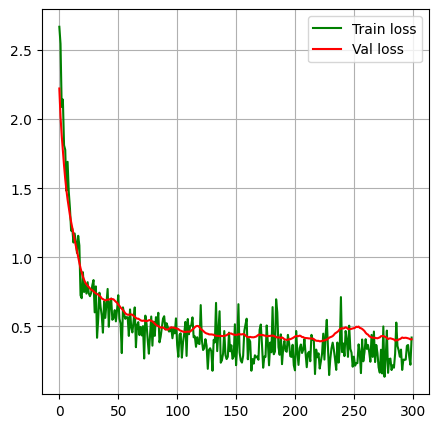

In [7]:
from torch import optim
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

from AdvanstMNISTMLP import AdvancedMNISTMLPList
from ml_dl_experiments.settings import settings
from ml_dl_experiments.dl.dl_modules.second_theme_PyTorch.load_mnist import load_mnist_to_batches


train_loader, val_loader, test_data = load_mnist_to_batches(
    download_from_source = False,
    path_to_loading=settings.SOURCE_PATH+"/ml_dl/second_theme_data",
    train_size_index=0.8
)



model = AdvancedMNISTMLPList()
model.train()
optimizer = optim.Adam(params=model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

epochs: int = 300
train_losses = []
val_losses = []

for i in range(epochs):
    images, labels = next(iter(train_loader))
    val_images, val_labels = next(iter(val_loader))
    model.train()
    out_seq = model(images)
    optimizer.zero_grad()
    train_loss = criterion(out_seq, labels)
    train_losses.append(train_loss.detach().numpy())
    train_loss.backward()
    optimizer.step()
    model.eval()
    val_preds = model(val_images)
    val_loss = criterion(val_preds, val_labels)
    val_losses.append(val_loss.detach().numpy())


plt.subplots(1, 1, figsize=(5, 5))
plt.plot(range(epochs), train_losses, c='g', label="Train loss")
plt.plot(range(epochs), val_losses, c='r', label="Val loss")
plt.legend()
plt.grid()
plt.show()

# Цикл обучения в PyTorch

Цикл обучения (training loop) — это последовательность шагов, выполняемых в процессе обучения нейронной сети. Обычно обучение разделяется на эпохи (epochs).

Одна эпоха — это полный проход по всему тренировочному набору данных. Каждый проход разбивается на итерации (batch iterations), в которых партия данных (batch) передаётся модели.

Вот как выглядят эти шаги обучения в PyTorch:

-  Переключение модели в режим обучения model.train(). Это важно, если в модели используются слои вроде Dropout или BatchNorm, которые ведут себя по-разному в режиме обучения и валидации.
- Подача пакета данных. Для каждого batch входные данные (изображения) и метки классов получают из DataLoader.
- Прямой проход (forward pass). Вычисляем выход модели outputs = model(inputs).
- Вычисление функции потерь loss = criterion(outputs, targets). Здесь criterion — заданная функция потерь. Она оценивает, насколько предсказанные выходы близки к истинным меткам.
- Обратный проход (backward pass). Перед оптимизацией обнуляем градиенты optimizer.zero_grad(), затем вызываем loss.backward(), чтобы вычислить градиенты функции потерь по весам модели.
- Обновление весов. optimizer.step() обновляет параметры модели по вычисленным градиентам.
- Сбор метрик. Аккумулируем величину потерь и правильных предсказаний для вычисления метрик (например, точности) по эпохе.
- Повтор. Переходим к следующему пакету данных.

После завершения всех итераций по батчам эпохи обычно выполняется оценка на валидационном или тестовом наборе (режим model.eval(), без изменения весов. Она нужна для мониторинга качества модели на данных, не участвовавших в обучении.

# Функция потерь: CrossEntropyLoss

Функция потерь (loss function) — ключевой компонент обучения нейронных сетей. Она переводит разницу между предсказаниями модели и истинными метками в численное значение, которое алгоритм стремится минимизировать.

Для задач многоклассовой классификации (например, распознавания цифр 0-9 в MNIST) одной из самых распространённых потерь является кросс‑энтропийная функция потерь CrossEntropyLoss — сочетание log-softmax и негативного логарифма правдоподобия.

## Определение CrossEntropyLoss

В контексте нейросетей модель на последнем слое обычно выдаёт логиты — ненормализованные числовые оценки принадлежности к каждому из классов:

$z=(z_1​,z_2​,…,z_C​), z_i​∈R,$

где C — число классов. 

Чтобы получить из логитов вероятности, применяется `Softmax`:

$$p_i​= \frac{e^{z_i}}{\sum_{j=1}^C ​e^{z_j}​​​},\sum_{i=1}^C ​p_i ​=1.$$

При этом для численной стабильности можно сразу вычислить `LogSoftmax`:

$$logp_i​=z_i​−log(\sum_{j=1}^C ​e^{z_j}​).$$

Затем вычисляется негативный логарифм правдоподобия (`NLLLoss`) для истинного класса t:

$$ℓ(z,t)=−logp_t​.$$

В PyTorch функция `nn.CrossEntropyLoss` сама объединяет `LogSoftmax` и `NLLLoss`:

```py
criterion = nn.CrossEntropyLoss()
loss = criterion(logits, target_indices) 
```

Если представить метки в виде `one‑hot` вектора $y=(y_1​,…,y_C​)$, где $y_t​=1$ для истинного класса и 0 иначе, формула кросс‑энтропии записывается так:

$$CE(y,p)=\sum_{i=1}^C​y_i​logp_i​=−logp_t​.$$

Таким образом, чем больше предсказанная вероятность $p_t​$ приближается к 1, тем меньше потерь. И наоборот: предсказание «наверняка неверно» ($pt​→0$) ведёт к неограниченно большому штрафу.